In [1]:
import barmuscomp.ae_utils as ae_utils
import barmuscomp.ae as ae
import barmuscomp.ae_ntd as ae_ntd
import barmuscomp.scripts.default_path as paths
import barmuscomp.scripts.overall_scripts as scr
import barmuscomp.model.features as features
from barmuscomp.model.current_plot import *

import as_seg.CBM_algorithm as CBM
import as_seg.barwise_input as bi
import as_seg.data_manipulation as dm
import as_seg.autosimilarity_computation as as_comp

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
## Important parameters
feature = "nn_log_mel_grill"
beta = 1
ntd_dimensions = [24,24,24]
plot_patterns = True
nb_patterns = 4
autosimilarity_type = "Cosine"
compute_if_not_persisted = False
verbose = False
latent_nonlinearity = "softmax"

In [3]:
subdivision = 96
hop_length = 32
hop_length_seconds = hop_length/44100

#song_name = "The Beatles - Come Together"
#spectrogram, bars, references_segments = scr.load_spec_annot_cometogether(feature, hop_length)
song_name = 1
spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)

batch_size = None
lr = 1e-3
n_epochs = 1000

tensor_spectrogram = bi.tensorize_barwise_BFT(spectrogram, bars, hop_length_seconds, subdivision)
fc_data_loader = ae_utils.generate_flatten_dataloader(tensor_spectrogram, batch_size = batch_size)
conv_data_loader = ae_utils.generate_dataloader(tensor_spectrogram, batch_size = batch_size)

freq_size = tensor_spectrogram.shape[1]

tensor_spectrogram_ntd = bi.tensorize_barwise_FTB(spectrogram, bars, hop_length_seconds, subdivision)

init_ntd = "tucker"
if beta == 2:
    persisted_arguments = f"_{song_name}_{feature}_{init_ntd}_{subdivision}"
    core, factors = scr.NTD_decomp_as_script(paths.path_data_persisted_come_together, persisted_arguments, tensor_spectrogram_ntd, ntd_dimensions, init = init_ntd, update_rule = "hals", beta = 2, compute_if_not_persisted = compute_if_not_persisted)
else:
    persisted_arguments = f"mu_slow_{song_name}_beta{beta}_{feature}_{init_ntd}_{subdivision}_n_iter_max1000"
    core, factors = scr.NTD_decomp_as_script(paths.path_data_persisted_come_together, persisted_arguments, tensor_spectrogram_ntd, ntd_dimensions, init = init_ntd, update_rule = "mu", beta = beta, compute_if_not_persisted = compute_if_not_persisted)
bn_latent_init_stds = [np.std(factors[2][:,i]) for i in range(factors[2].shape[1])]
bn_latent_init_avgs = [np.mean(factors[2][:,i]) for i in range(factors[2].shape[1])]

if beta == 2:
    recons_loss = torch.nn.MSELoss()
else:
    recons_loss = ae_utils.BetaDivergenceLoss(beta)

In [6]:
def get_projection_score(projection, autosimilarity_type = autosimilarity_type, convolution_type = "14_bands"):
    projection = np.array(projection)
    projection = np.where(abs(projection) < 1e-15, 0, projection)
    
    autosimilarity = as_comp.switch_autosimilarity(projection, similarity_type = autosimilarity_type, normalise = True)
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = 1, penalty_func = "modulo8", convolution_type = convolution_type)[0]                
    segments_in_time = dm.segments_from_bar_to_time(segments, bars)

    f_mes_zero_five = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)[2]
    f_mes_three = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)[2]
    
    print(f"Score at 0.5s: {f_mes_zero_five}, score at 3s: {f_mes_three}")
    
def plot_audio_diff_ntd_ae_in_dataframe(signal_ntd, signal_ae):
    df = pd.DataFrame(np.array([signal_ntd, signal_ae]), index = ["Audio NTD", "Audio AE"])
    for i in range(df.shape[1]):
        df[i] = df[i].T.apply(lambda x:x._repr_html_().replace('\n', '').strip())#, axis=1)
    df_html = df.T.to_html(escape=False, index=False)
    ipd.display(ipd.HTML(df_html))
    
def plot_spec_ntd_ae(spec_1, spec_2, title, to_permute = True, plot_diff = False):
    if spec_1.shape[0] == spec_1.shape[1]:
        fig, axs = plt.subplots(1, 2, figsize=(14,7))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(15,min(5, 15*spec_1.shape[0]/spec_1.shape[1])))
    if to_permute:
        permut_1 = permutate_factor(spec_1.T) 
        spec_1 = spec_1[permut_1]
        permut_2 = permutate_factor(spec_2.T)
        spec_2 = spec_2[permut_2]
    diff = spec_2 - spec_1
    axs[0].pcolormesh(np.arange(spec_1.shape[1]), np.arange(spec_1.shape[0]), spec_1, cmap=cm.Greys, shading='auto')
    axs[0].set_title(f"{title} of NTD")
    axs[1].pcolormesh(np.arange(spec_2.shape[1]), np.arange(spec_2.shape[0]), spec_2, cmap=cm.Greys, shading='auto')
    axs[1].set_title(f"{title} of AE")
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    plt.show()
    if plot_diff:
        if spec_1.shape[0] == spec_1.shape[1]:
            fig, axs = plt.subplots(1, 2, figsize=(14,7))
        else:
            fig, axs = plt.subplots(1, 2, figsize=(15,min(5, 15*spec_1.shape[0]/spec_1.shape[1])))
        axs[0].pcolormesh(np.arange(diff.shape[1]), np.arange(diff.shape[0]), diff, cmap=cm.Greys, shading='auto')
        axs[0].set_title(f"Diff entre les 2 spectrogrammes\n (couleurs normalisées entre min et max)\n Diff maximale: {np.amax(np.abs(diff))}")
        the_max = max(np.amax(spec_1), np.amax(spec_2))
        axs[1].pcolormesh(np.arange(diff.shape[1]), np.arange(diff.shape[0]), diff, cmap=cm.Greys, vmin=0, vmax=the_max, shading='auto')
        axs[1].set_title(f"Diff entre les 2 spectrogrammes\n (couleurs normalisées entre 0 et max des 2 spectrogrammes)\n Valeur max des 2 specs{the_max}")
        axs[0].invert_yaxis()
        axs[1].invert_yaxis()
        plt.show()

In [7]:
hops = []
for bar_idx in range(tensor_spectrogram_ntd.shape[2]):
    len_sig = bars[bar_idx+1][1] - bars[bar_idx+1][0]
    hop = int(len_sig/96 * 44100)
    hops.append(hop)
median_hop = int(np.median(hops)) #For audio reconstruction

def plot_patterns_ae_and_ntd(spec_patterns_ntd, patterns_ntd, core_ae, factors_ae, nb_patterns = nb_patterns):
    for i in range(nb_patterns):
        pattern = factors_ae[0]@core_ae[:,:,i]@factors_ae[1].T
        plot_spec_ntd_ae(spec_patterns_ntd[i], pattern, title = f"{i}-th pattern in the decoder", to_permute = False)
        audio = features.get_audio_from_spectrogram(pattern, feature, hop_length = median_hop, sr = 44100)
        plot_audio_diff_ntd_ae_in_dataframe(patterns_ntd[i], audio)
        
def plot_comparison_this_ae_ntd(ssae, projection):
    autosimil = as_comp.switch_autosimilarity(projection, similarity_type = autosimilarity_type, normalise = True)
    plot_spec_ntd_ae(autosimilarity_ntd, autosimil, "Autosimilarity", to_permute = False)
    get_projection_score(projection)

    W = ssae.get_W()
    H = ssae.get_H()
    proj_np = np.array(projection).T

    plot_spec_ntd_ae(factors[0], W, title = "W matrix")
    plot_spec_ntd_ae(factors[1].T, H.T, title = "H matrix")
    plot_spec_ntd_ae(factors[2].T, proj_np, title = "Latent representations")
    if plot_patterns:
        G = ssae.get_G()
        plot_patterns_ae_and_ntd(spec_patterns_ntd, patterns_ntd, G, [W, H])

# Résultats NTD

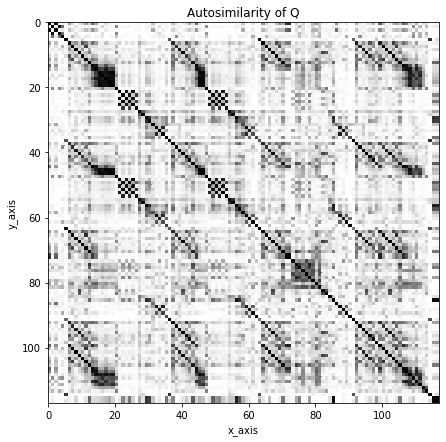

Score at 0.5s: 0.5777777777777778, score at 3s: 0.888888888888889
NTD reconstruction error: 0.4273962378501892


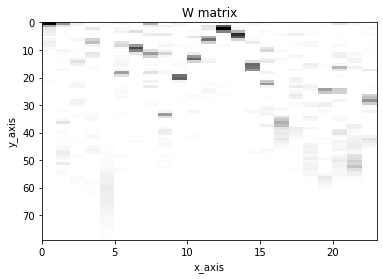

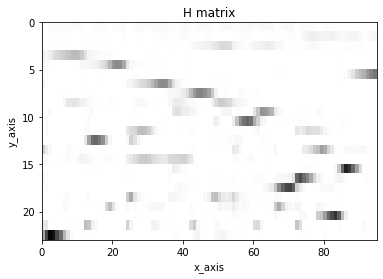

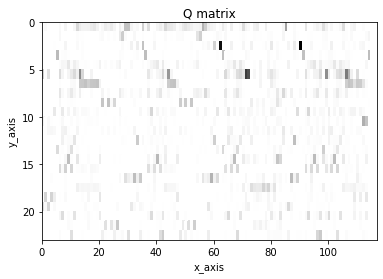

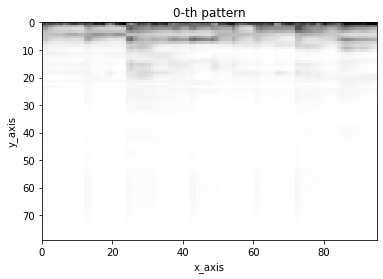

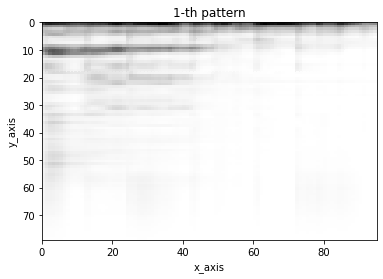

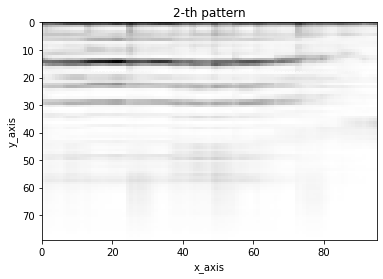

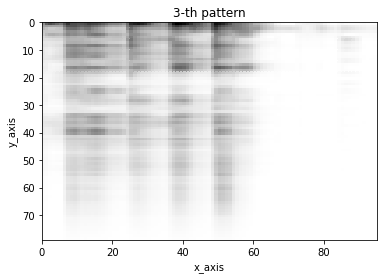

In [8]:
recons = tl.tenalg.multi_mode_dot(core, factors)

autosimilarity_ntd = as_comp.switch_autosimilarity(factors[2], similarity_type = autosimilarity_type, normalise = True)
plot_me_this_spectrogram(autosimilarity_ntd, title = "Autosimilarity of Q")
get_projection_score(factors[2])
print(f"NTD reconstruction error: {recons_loss(torch.tensor(tensor_spectrogram_ntd).float(), torch.tensor(recons).float())}")

plot_me_this_spectrogram(factors[0], title = "W matrix")
plot_me_this_spectrogram(factors[1].T, title = "H matrix")
plot_me_this_spectrogram(factors[2].T, title = "Q matrix")
if plot_patterns:
    patterns_ntd = []
    spec_patterns_ntd = []
    for i in range(nb_patterns):
        pattern = factors[0]@core[:,:,i]@factors[1].T
        spec_patterns_ntd.append(pattern)
        plot_me_this_spectrogram(pattern, title = f"{i}-th pattern")
        audio = features.get_audio_from_spectrogram(pattern, feature, hop_length = median_hop, sr = 44100)
        patterns_ntd.append(audio)
        ipd.display(audio)

# Décodeur Aléatoire

## FC

Using cpu
Final reconstruction error: 2.6331534385681152


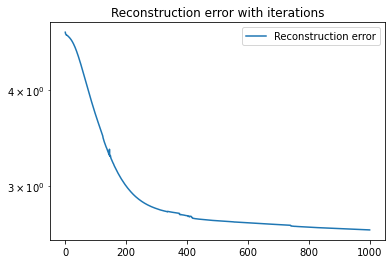

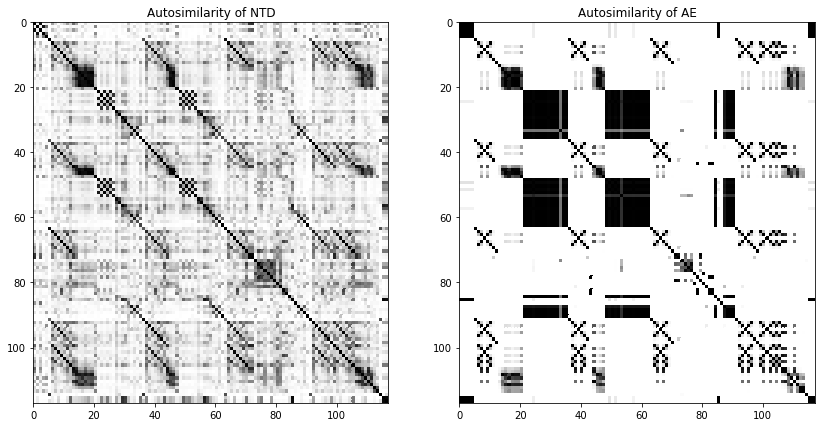

Score at 0.5s: 0.4444444444444445, score at 3s: 0.8444444444444444


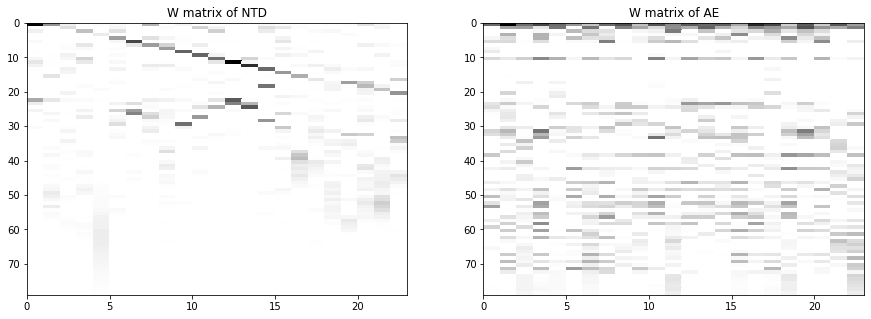

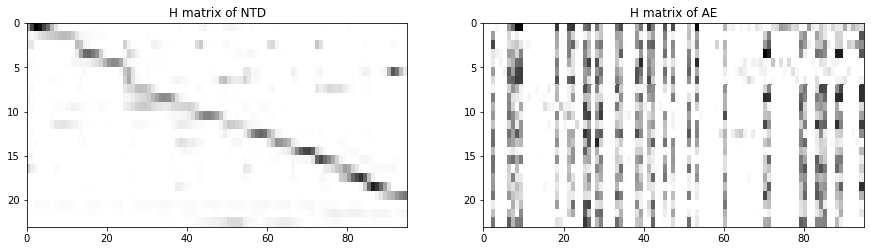

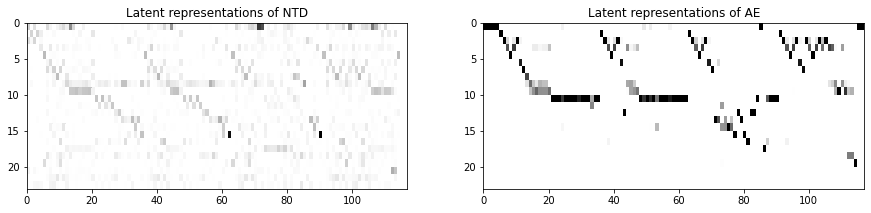

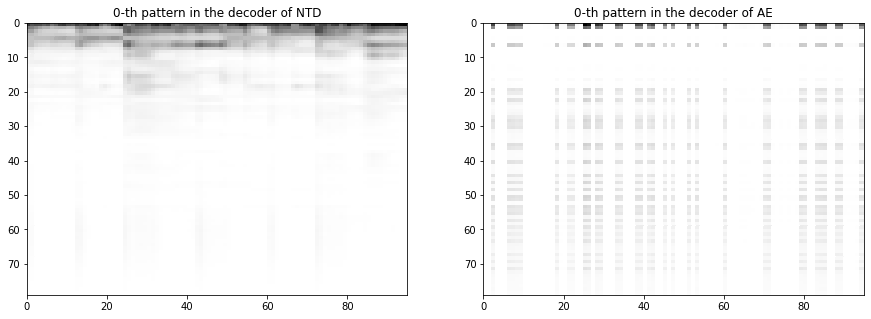

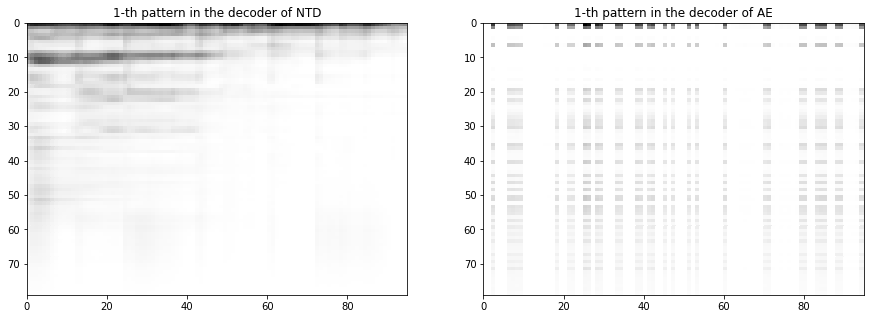

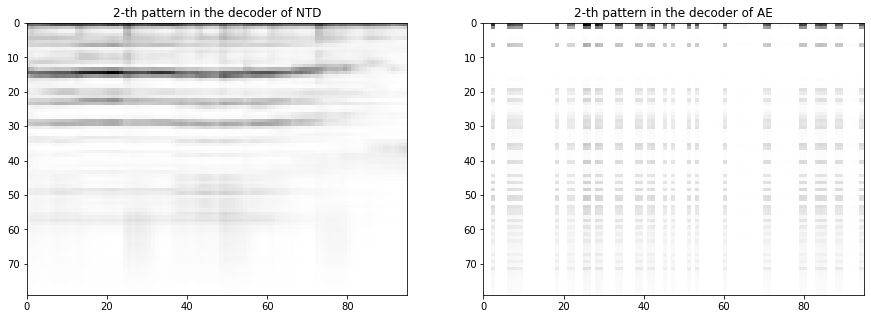

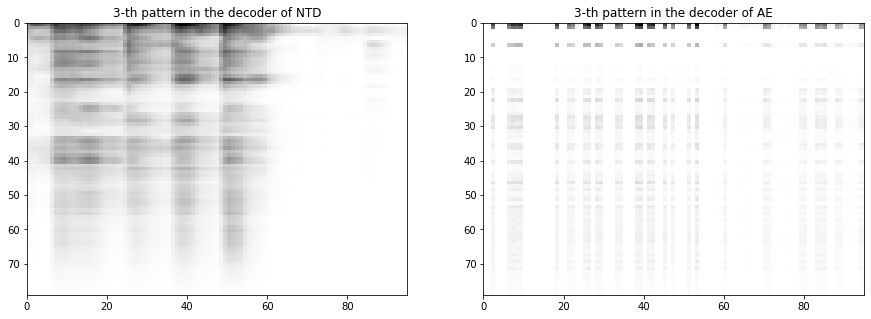

In [7]:
fc_random_decoder = ae_ntd.FullyConnectedAutoencoderNTD(input_size_x = subdivision, input_size_y = freq_size, 
                                                        ntd_dimensions = ntd_dimensions, unfolded_G = None, W = None, H = None,
                                                        bn_latent_init_stds = None, bn_latent_init_avgs = None,
                                                        beta = beta, seed = 42, latent_nonlinearity = latent_nonlinearity)
fc_random_decoder, losses = fc_random_decoder.my_optim_method(n_epochs, fc_data_loader, verbose = verbose, lr = lr)
print(f"Final reconstruction error: {losses[-1]}")
plt.plot(losses)
plt.title("Reconstruction error with iterations")
plt.legend(["Reconstruction error"])
plt.yscale('log')
plt.show()

projection_fc_random = fc_random_decoder.get_latent_projection(fc_data_loader)
plot_comparison_this_ae_ntd(fc_random_decoder, projection_fc_random)

# Décodeur avec W et H "apprises"

In [9]:
import sklearn.cluster

path_to_save_cluster = "C:/Users/amarmore/Desktop/data_persisted/cluster_matrices"

## W et H apprises -> clustering de toutes les colonnes des NTD réalisées avec ces rangs sur RWC Pop.

### Matrices contenant toutes les colonnes de W (resp. H) pour les chansons de RWC Pop

In [10]:
big_h = []
big_w = []
for song_name in range(1,101):
    if beta == 2:
        persisted_arguments = f"_{song_name}_{feature}_{init_ntd}_{subdivision}"
        _, factors_tmp = scr.NTD_decomp_as_script(paths.path_data_persisted_rwc, persisted_arguments, None, ntd_dimensions, init = init_ntd, update_rule = "hals", beta = 2, compute_if_not_persisted = False)
    else:
        persisted_arguments = f"mu_slow_{song_name}_beta{beta}_{feature}_{init_ntd}_{subdivision}_n_iter_max1000"
        _, factors_tmp = scr.NTD_decomp_as_script(paths.path_data_persisted_rwc, persisted_arguments, None, ntd_dimensions, init = init_ntd, update_rule = "mu", beta = beta, compute_if_not_persisted = False)
    
    for column_h in factors_tmp[1].T:
        big_h.append(column_h)
    for column_w in factors_tmp[0].T:
        big_w.append(column_w)

### Centre des clusters pour H

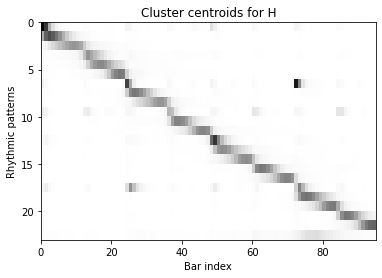

In [12]:
kmeansh = sklearn.cluster.KMeans(n_clusters = ntd_dimensions[1], random_state = 42).fit(big_h)
k_means_h = kmeansh.cluster_centers_
k_means_h = k_means_h.T
np.save(f"{path_to_save_cluster}/kmeans_H_rwcpop_dimensions{ntd_dimensions}_beta{beta}", k_means_h)
#k_means_h = np.load(f"{path_to_save_cluster}/kmeans_H_rwcpop_dimensions{ntd_dimensions}_beta{beta}.npy")
perm_cluster_h = permutate_factor(k_means_h)
plot_me_this_spectrogram(k_means_h[:,perm_cluster_h].T, title = "Cluster centroids for H", x_axis = "Bar index", y_axis = "Rhythmic patterns")  

###  Centre des clusters pour W

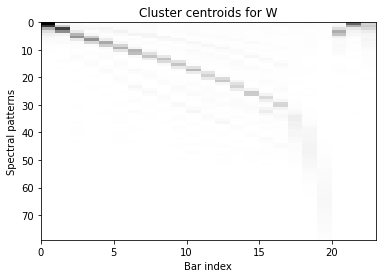

In [11]:
kmeansw = sklearn.cluster.KMeans(n_clusters = ntd_dimensions[0], random_state = 42).fit(big_w)
k_means_w = kmeansw.cluster_centers_
k_means_w = k_means_w.T
np.save(f"{path_to_save_cluster}/kmeans_W_rwcpop_dimensions{ntd_dimensions}_beta{beta}", k_means_w)
#k_means_w = np.load(f"{path_to_save_cluster}/kmeans_W_rwcpop_dimensions{ntd_dimensions}_beta{beta}.npy")
perm_cluster_w = permutate_factor(k_means_w)
plot_me_this_spectrogram(k_means_w[:,perm_cluster_w], title = "Cluster centroids for W", x_axis = "Bar index", y_axis = "Spectral patterns")  

## FC

Using cpu
Final reconstruction error: 1.418982982635498


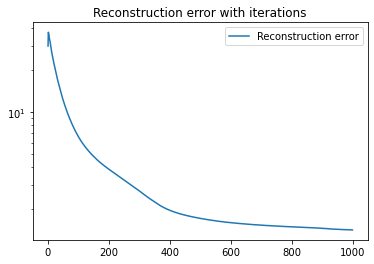

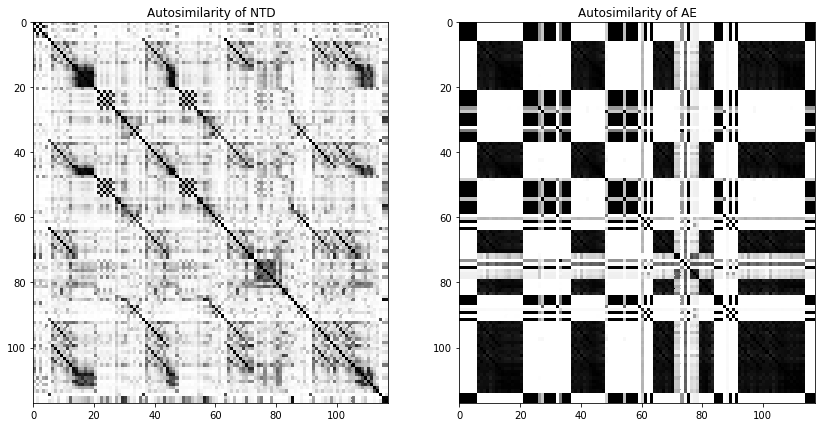

Score at 0.5s: 0.8372093023255814, score at 3s: 0.8837209302325583


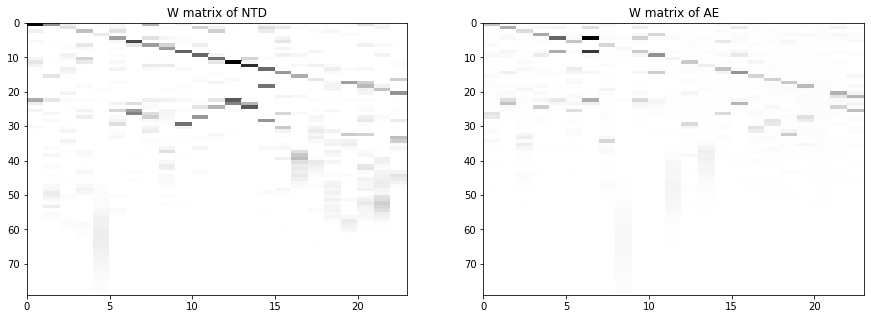

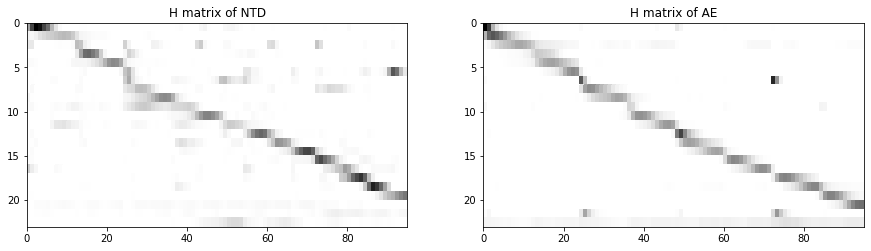

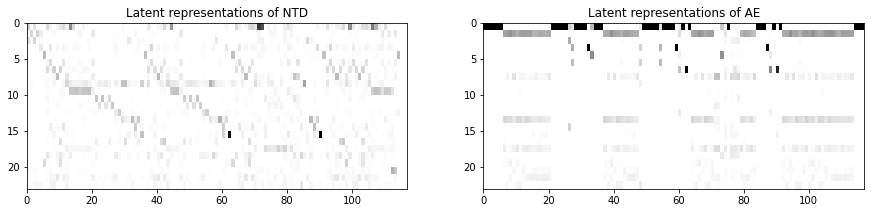

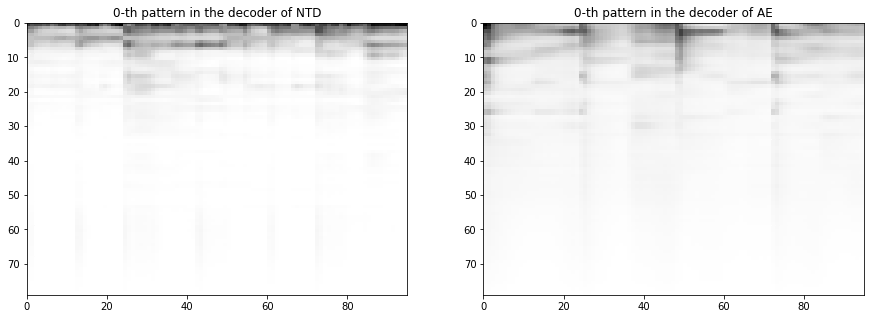

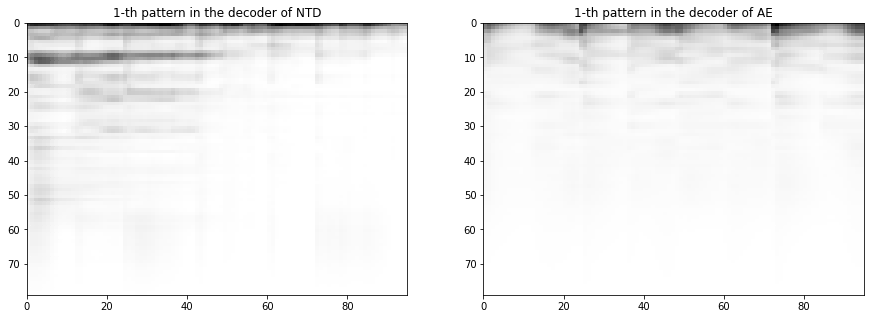

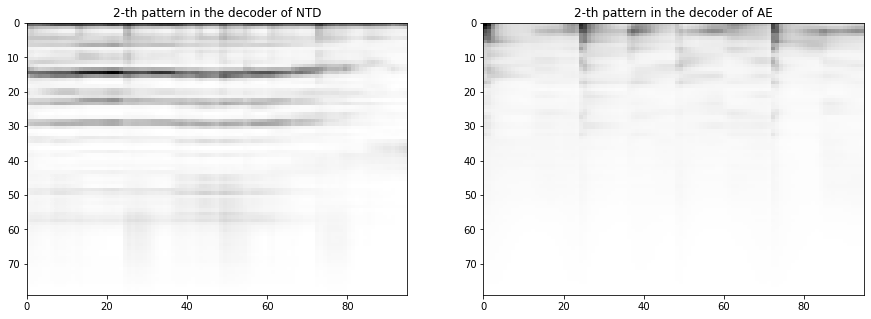

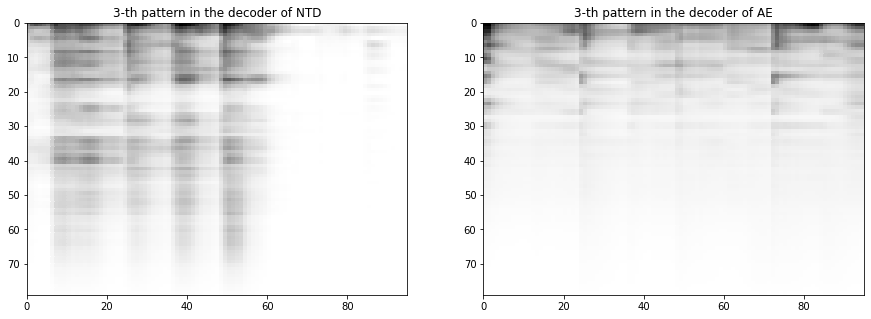

In [12]:
fc_init_centroid = ae_ntd.FullyConnectedAutoencoderNTD(input_size_x = subdivision, input_size_y = freq_size, 
                                                        ntd_dimensions = ntd_dimensions, unfolded_G = None, W = k_means_w, H = k_means_h,
                                                        bn_latent_init_stds = None, bn_latent_init_avgs = None,
                                                        beta = beta, seed = 42, latent_nonlinearity = latent_nonlinearity)
fc_init_centroid, losses = fc_init_centroid.my_optim_method(n_epochs, fc_data_loader, verbose = verbose, lr = lr)
print(f"Final reconstruction error: {losses[-1]}")
plt.plot(losses)
plt.title("Reconstruction error with iterations")
plt.legend(["Reconstruction error"])
plt.yscale('log')
plt.show()

projection_fc_init_centroid = fc_init_centroid.get_latent_projection(fc_data_loader)
plot_comparison_this_ae_ntd(fc_init_centroid, projection_fc_init_centroid)

# Décodeur initalisé avec NTD

## FC

Using cpu
Final reconstruction error: 0.736495852470398


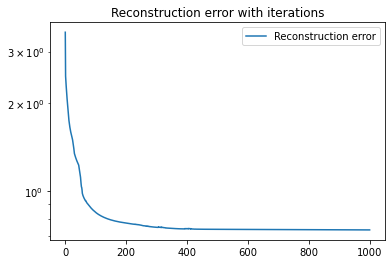

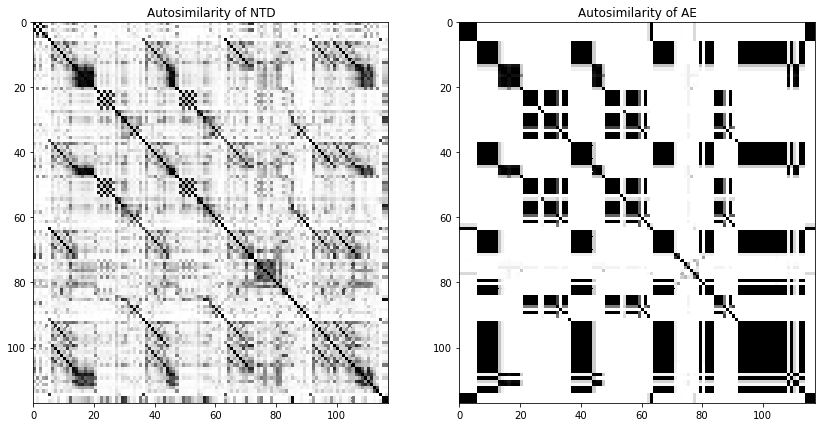

Score at 0.5s: 0.6666666666666666, score at 3s: 0.8


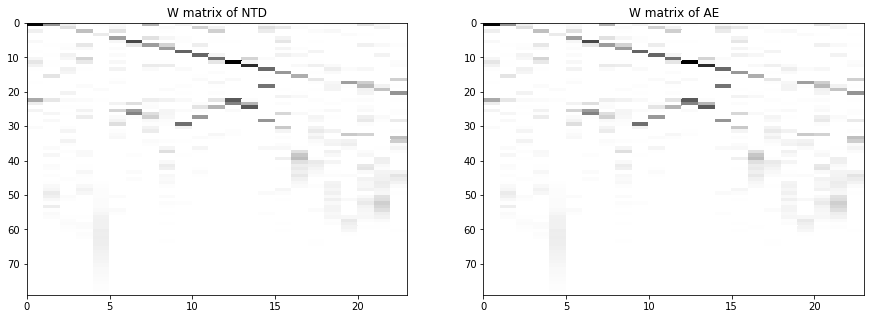

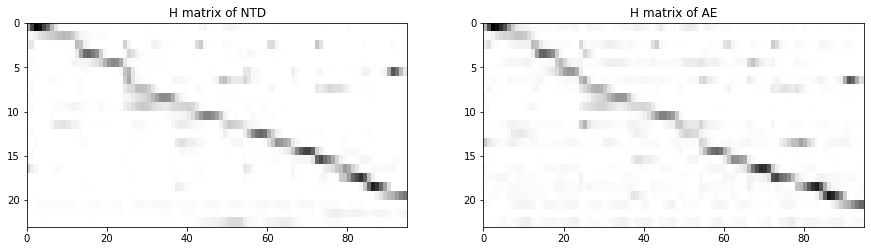

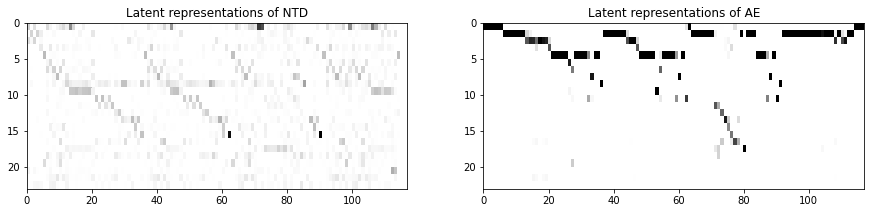

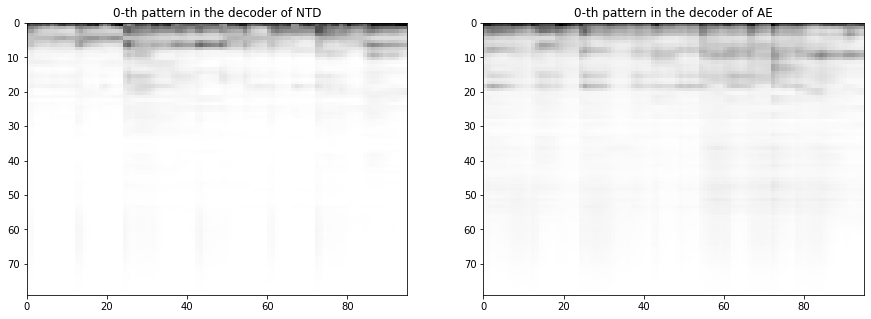

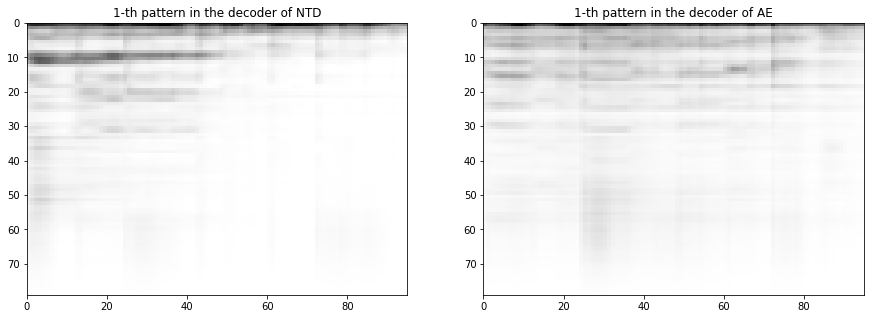

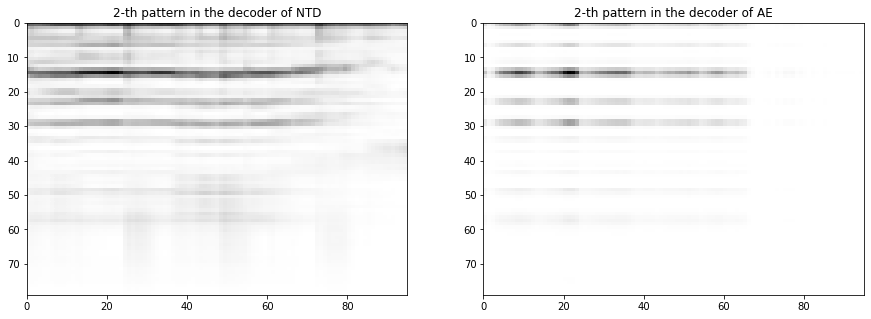

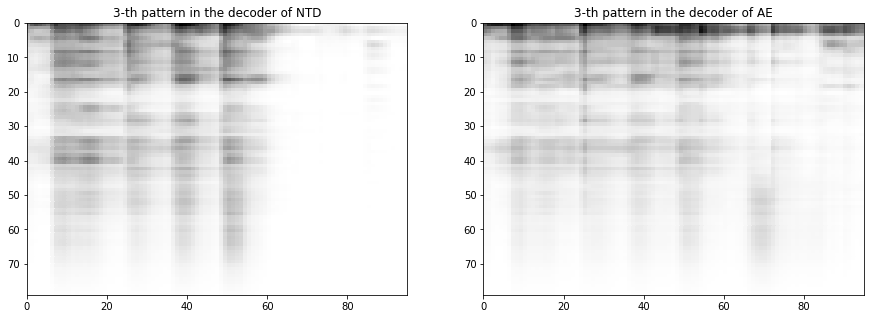

In [13]:
fc_init_ntd = ae_ntd.FullyConnectedAutoencoderNTD(input_size_x = subdivision, input_size_y = freq_size, 
                                                        ntd_dimensions = ntd_dimensions, unfolded_G = tl.unfold(core, 2),
                                                        W = factors[0], H = factors[1],
                                                        bn_latent_init_stds = bn_latent_init_stds, bn_latent_init_avgs = bn_latent_init_avgs,
                                                        beta = beta, seed = 42, latent_nonlinearity = latent_nonlinearity)
fc_init_ntd, losses = fc_init_ntd.my_optim_method(n_epochs, fc_data_loader, verbose = verbose, lr = lr)
print(f"Final reconstruction error: {losses[-1]}")
plt.plot(losses)
plt.title("Reconstruction error with iterations")
plt.legend(["Reconstruction error"])
plt.yscale('log')
plt.show()

projection_fc_init_ntd = fc_init_ntd.get_latent_projection(fc_data_loader)
plot_comparison_this_ae_ntd(fc_init_ntd, projection_fc_init_ntd)